# Prediction of velocity structure

With this notebook the velocity structure of the upper 100m can be estimated using Love and Rayleigh dispersion curves and H/V curve as input data.

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from pickle import load
import keras
import tensorflow as tf
import pandas as pd
from scipy import stats

### Import and preprocessing of input data
For example as csv file: needs column for frequency (freq in Hz), phase velocity (vel in m/s) and standard deviation (std in m/s)   
Data should be in a frequency range of 1 - 20 Hz

In [2]:
#import data
love = pd.read_csv("./test_data/input_lov_disp.csv")
rayleigh = pd.read_csv("./test_data/input_ray_disp.csv")
hv=pd.read_csv("./test_data/HV.csv")

print(love)

         freq         vel        std
0    1.000000  911.224490  90.996197
1    1.030698  911.224490  90.996197
2    1.062338  911.224490  90.996197
3    1.094949  911.224490  90.996197
4    1.128562  911.224490  90.996197
..        ...         ...        ...
95  17.679694  330.838859  64.394260
96  18.222420  327.143299  62.198238
97  18.781807  326.029205  60.774419
98  19.358366  321.088848  68.810457
99  19.952623  314.436620  64.101982

[100 rows x 3 columns]


In [3]:
lov_freq=np.array(love[["freq"]][:],dtype=float)
lov_freq=np.reshape(lov_freq,(len(lov_freq)))
lov_disp=np.array(love[["vel"]][:],dtype=float)
lov_disp=np.reshape(lov_disp,(len(lov_disp)))
lov_un=np.array(love[["std"]][:],dtype=float)
lov_un=np.reshape(lov_un,(len(lov_un)))

ray_freq=np.array(rayleigh[["freq"]][:],dtype=float)
ray_freq=np.reshape(ray_freq,(len(ray_freq)))
ray_disp=np.array(rayleigh[["vel"]][:],dtype=float)
ray_disp=np.reshape(ray_disp,(len(ray_disp)))
ray_un=np.array(rayleigh[["std"]][:],dtype=float)
ray_un=np.reshape(ray_un,(len(ray_un)))

hv_freq=np.array(hv[["freq"]][:],dtype=float)
hv_freq=np.reshape(hv_freq,(len(hv_freq)))
hv_ell=np.array(hv[["hv"]][:],dtype=float)
hv_ell=np.reshape(hv_ell,(len(hv_ell)))
hv_un=np.array(hv[["std"]][:],dtype=float)
hv_un=np.reshape(hv_un,(len(hv_un)))

In [4]:
np.shape(lov_freq)

(100,)

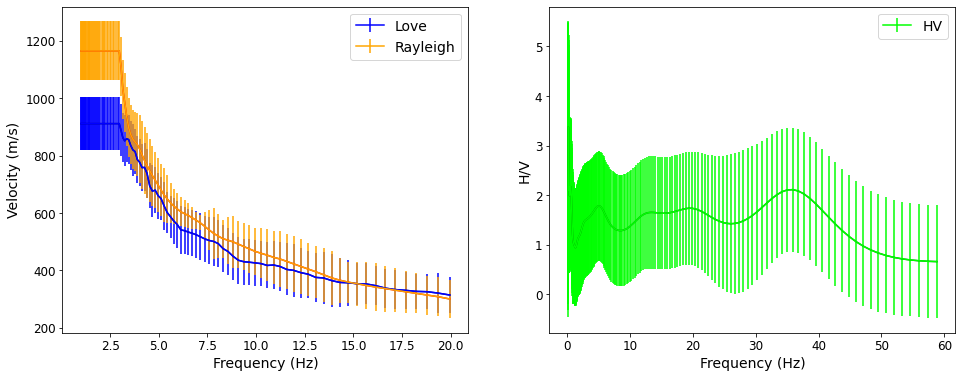

In [5]:
#plot input data
fig=plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)

ax1.plot(lov_freq,lov_disp,color="darkblue")
plt.errorbar(lov_freq,lov_disp,lov_un,color="blue",label="Love")
ax1.plot(ray_freq,ray_disp,color="red")
plt.errorbar(ray_freq,ray_disp,ray_un,color="orange",label="Rayleigh")
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Frequency (Hz)", fontsize=14)
plt.ylabel("Velocity (m/s)",fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(hv_freq,hv_ell,color="green")
plt.errorbar(hv_freq,hv_ell,hv_un,color="lime",label="HV")
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Frequency (Hz)", fontsize=14)
plt.ylabel("H/V",fontsize=14)
plt.show()

In [6]:
#resample data logarithmic with 100 samples between 1- 20 Hz 
freq_re=np.logspace(0,1.3,100,base=10)

lov_disp_re=np.interp(freq_re,lov_freq,lov_disp)
lov_un_re=np.interp(freq_re,lov_freq,lov_un)

ray_disp_re=np.interp(freq_re,ray_freq,ray_disp)
ray_un_re=np.interp(freq_re,ray_freq,ray_un)

hv_ell_re=np.interp(freq_re,hv_freq,hv_ell)
hv_un_re=np.interp(freq_re,hv_freq,hv_un)

In [7]:
np.shape(lov_disp_re)

(100,)

In [8]:
#data have to be in km/s
lov_disp_re=lov_disp_re/1000
lov_un_re=lov_un_re/1000
ray_disp_re=ray_disp_re/1000
ray_un_re=ray_un_re/1000

In [9]:
#reshape data to fit into NN
lov_disp_re=np.reshape(lov_disp_re,(1,100))
lov_un_re=np.reshape(lov_un_re,(1,100))

ray_disp_re=np.reshape(ray_disp_re,(1,100))
ray_un_re=np.reshape(ray_un_re,(1,100))

hv_ell_re=np.reshape(hv_ell_re,(1,100))
hv_un_re=np.reshape(hv_un_re,(1,100))

print(np.shape(lov_disp_re))

(1, 100)


### Prediction Layer Number

In [10]:
#import classification NN
model_class = tf.keras.models.load_model('./trained_models/model_classification_NN_HV.h5')



In [11]:
#import scalers
scaler1_class = load(open('./trained_models/scaler1_class_NN_HV.pkl', 'rb')) #for Love dispersion
scaler2_class = load(open('./trained_models/scaler2_class_NN_HV.pkl', 'rb')) #for Love uncertainty
scaler3_class = load(open('./trained_models/scaler3_class_NN_HV.pkl', 'rb')) #for Rayleigh dispersion 
scaler4_class = load(open('./trained_models/scaler4_class_NN_HV.pkl', 'rb')) #for Rayleigh uncertainty
scaler5_class = load(open('./trained_models/scaler5_class_NN_HV.pkl', 'rb')) #for HV curve
scaler6_class = load(open('./trained_models/scaler6_class_NN_HV.pkl', 'rb')) #for HV uncertainty


In [12]:
#scale data
lov_disp_scal=scaler1_class.transform(lov_disp_re.copy())
lov_un_scal=scaler2_class.transform(lov_un_re.copy())
ray_disp_scal=scaler3_class.transform(ray_disp_re.copy())
ray_un_scal=scaler4_class.transform(ray_un_re.copy())
hv_scal=scaler5_class.transform(hv_ell_re.copy())
hv_un_scal=scaler6_class.transform(hv_un_re.copy())

In [13]:
#predict layer number
layer_pred=model_class.predict([lov_disp_scal,lov_un_scal,ray_disp_scal,ray_un_scal,hv_scal,hv_un_scal])


In [14]:
print((layer_pred.shape)) 

(1, 6)


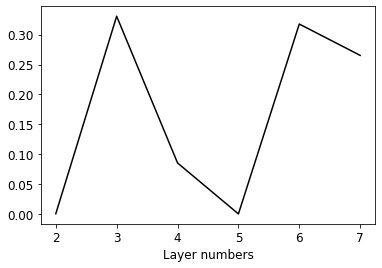

In [15]:
#plot results
x=np.linspace(2,7,6)
plt.plot(x,layer_pred[0],color="black")
plt.xlabel("Layer numbers",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [16]:
#optimum layer number
number=np.argmax(layer_pred)+2
print("Predicted layer number: ",number)

Predicted layer number:  3


### Prediction Velocity Structure

In [17]:
#pick trained MDN depending on predicted layer number and also on HV
model_MDN = tf.keras.models.load_model('./trained_models/model_layers{}_MDN_HV.h5'.format(number),compile=False)



In [18]:
#import scalers
scaler1_MDN = load(open('./trained_models/scaler1_layers{}_MDN_HV.pkl'.format(number), 'rb')) #for Love dispersion
scaler2_MDN = load(open('./trained_models/scaler2_layers{}_MDN_HV.pkl'.format(number), 'rb')) #for Love uncertainty
scaler3_MDN = load(open('./trained_models/scaler3_layers{}_MDN_HV.pkl'.format(number), 'rb')) #for Rayleigh dispersion 
scaler4_MDN = load(open('./trained_models/scaler4_layers{}_MDN_HV.pkl'.format(number), 'rb')) #for Rayleigh uncertainty
scaler5_MDN = load(open('./trained_models/scaler5_layers{}_MDN_HV.pkl'.format(number), 'rb')) #for H/V
scaler6_MDN = load(open('./trained_models/scaler6_layers{}_MDN_HV.pkl'.format(number), 'rb')) #for H/V uncertainty



In [19]:
#scale data
lov_disp_scal=scaler1_MDN.transform(lov_disp_re.copy())
lov_un_scal=scaler2_MDN.transform(lov_un_re.copy())
ray_disp_scal=scaler3_MDN.transform(ray_disp_re.copy())
ray_un_scal=scaler4_MDN.transform(ray_un_re.copy())
hv_scal=scaler5_MDN.transform(hv_ell_re.copy())
hv_un_scal=scaler6_MDN.transform(hv_un_re.copy())

In [20]:
vel_pred,depth_pred=model_MDN.predict([lov_disp_scal,lov_un_scal,ray_disp_scal,ray_un_scal,hv_scal,hv_un_scal])


In [21]:
print((vel_pred.shape)) #MDN output
print((depth_pred.shape)) #deterministic depth values

(1, 50)
(1, 3)


In [22]:
#transform MDN output
vel=np.linspace(0,2.5,6000) #samples for x-axis
y_size=number
m=10 #number of Gaussians


predicted_means=[]
kernels=[]

for n in range(len(vel_pred)):  #split prediction vector in means, stdev and alpha
    means=vel_pred[n][0:y_size*m] 
    stdev=vel_pred[n][y_size*m:y_size*m+m]
    alpha=vel_pred[n][y_size*m+m:]
    model_mean=[]
    model_kernel= []
    for o in range(y_size):
        add=0
        for i in range(m):  #add all gaussian kernels
            kernel=alpha[i]*stats.norm.pdf(vel,means[o*m+i],abs(stdev[i]))
            add = add + kernel
        vel_estimate=vel[np.argmax(add)] #take maximum in gaussian kernel as velocity estimate for the layer
        model_mean.append(vel_estimate)
        model_kernel.append(add)
    predicted_means.append(model_mean)
    kernels.append(model_kernel)

In [23]:
print("predicted mean velocities: ",predicted_means)
print("predicted depth of layer boundaries: ",depth_pred)

predicted mean velocities:  [[0.30838473078846473, 0.633438906484414, 1.3656442740456742]]
predicted depth of layer boundaries:  [[ 9.475189 33.163616 98.72556 ]]


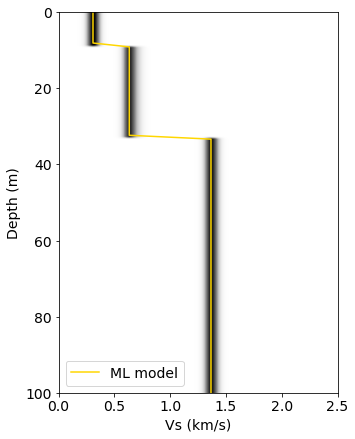

In [24]:
#plot velocity structure

x=np.linspace(0,2.5,6000) #samples for x-axis
y=np.linspace(0,100,100) #samples for y-axis

#transform layer depth into layer thickness
layer_thickness=[]
lay1=int(depth_pred[0][0])
layer_thickness.append(lay1)

for n in range(number-2):
    lay=int(depth_pred[0][n+1])-np.sum(layer_thickness)
    layer_thickness.append(lay)
    
lay_last=100-np.sum(layer_thickness)
layer_thickness.append(lay_last)


#velocities
vel_model=[]
for n in range(number):
    for i in range(layer_thickness[n]):
        vel_model.append(predicted_means[0][n])
        
extent = [x.min(), x.max(), y.min(), y.max()]
layers=np.flip(layer_thickness) #layers have to be in reverse order!!


#plotting of pdf
z_list=[]
for n in range(number):
    for i in range(layers[n]):
        pdf = kernels[0][y_size-1-n]
        z_list.append(pdf)
  

#plot
fig=plt.figure(figsize=(5,7))
fig.subplots_adjust(wspace=0.3)

ax1=fig.add_subplot(111)
ax1.plot(vel_model,y,label="ML model",color="gold")
ax1.imshow(z_list, extent=extent, aspect = 'auto',cmap=plt.cm.Greys)
plt.gca().invert_yaxis()
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14,loc='lower left')
plt.xlim(0,2.5)
plt.xlabel("Vs (km/s)",fontsize=14)
plt.ylabel("Depth (m)",fontsize=14)
plt.show()